# CNN Classification

In this lab, we will

- learn how to build and train a CNN model using Pytorch
- learn about MNIST dataset
- experiment with hyper-parameters tuning


Model development `Life-cycle`:
1. Prepare the `data`
2. Define the `model architecture`
3. Train the model
4. Evaluate the model
5. Deploy the model


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time


## Lets download MNIST data

In [ ]:
# load the training data
transform = torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
                                          ])

train_ds = torchvision.datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
test_ds = torchvision.datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)

In [5]:
print(len(train_ds))
print(len(test_ds))

60000
10000


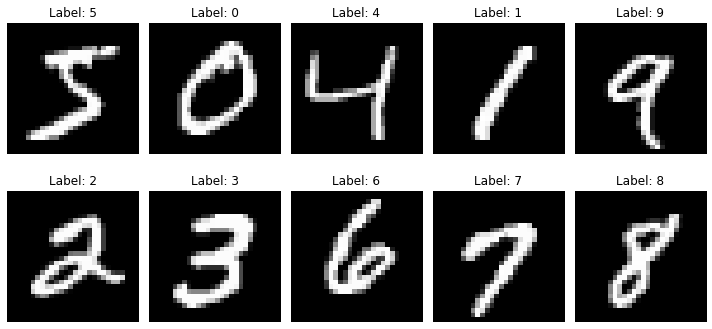

In [6]:
# Create a dictionary to store one image per label
images_per_label = {}

# Loop through the dataset to find one image per label
for img, label in train_ds:
    if label not in images_per_label:
        images_per_label[label] = img
    if len(images_per_label) == 10:  # Break the loop once we have all labels
        break

# Plot the images, one per label
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, (label, img) in enumerate(images_per_label.items()):
    ax = axes[i // 5, i % 5]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Initialize HyperParams

In [7]:
# Hyperparameters
lr = 0.01
batch_size = 64
num_epoch = 10
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


/opt/conda/lib/python3.9/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
# keep original before truncating
full_train = list(train_ds)

train_ds  = full_train[:10000]
valid_ds  = full_train[10000:12000]
test_ds   = list(test_ds)[:2000]

train_loader = torch.utils.data.DataLoader(train_ds, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(valid_ds, 
                                           batch_size=batch_size, 
                                           shuffle=False, 
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(test_ds, 
                                          batch_size=batch_size, 
                                          shuffle=False, 
                                          num_workers=2)

In [10]:
train_ds[0][0].shape

torch.Size([1, 28, 28])

## Define the model

- Convolutional Neural Network (CNN)

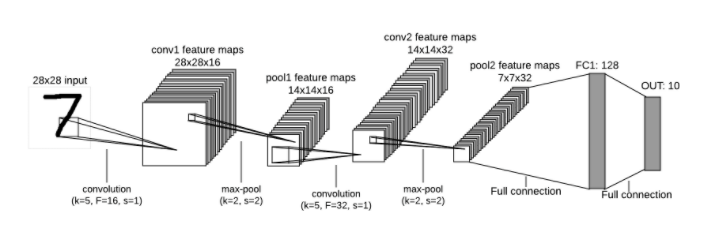

**The model architecture that we are going to build**

Input => conv1 => maxpooling => FC => output

In [ ]:
class MyCNN(nn.Module):                             # define own MyCNN which inherits nn.Module as a base class
  def __init__(self):
    super(MyCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3)    # conv2d(in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True)
    # (28-3+2*0)/1 + 1 = 26                         # output size = (W−K+2P)/S + 1
    self.maxpool = nn.MaxPool2d(2)
    # (26/2)
    self.fc1 = nn.Linear(13*13*16, 10)              # Flattened output from convolution followed by pooling layer

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.maxpool(x)
    x = torch.flatten(x,1)                          # feature maps flattened to 1D tensor output. second dimension (1) refers to flattening across the features, leaving the batch dimension intact.
    x = self.fc1(x)                                 # produces an output of size 10 (one score for each class)
    return x, F.log_softmax(x, dim=1)               # raw output from x (logits), log of softmax of x which normalizes the logits into prob.

In [13]:
cnn_model = MyCNN()
cnn_model = cnn_model.to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [14]:
print(cnn_model)

MyCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2704, out_features=10, bias=True)
)


In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train(train_loader=train_loader):
    cnn_model.train()                                      # sets model to training mode (dropout and batchnorm behaves in this mode)
    train_corr, train_total, train_running_loss = 0, 0, 0  # counters for tracting trainning accuracy, total examples, running loss

    for step, (data, y) in enumerate(train_loader):        # loops over batch of data in train_loader
        data, y = data.to(device), y.to(device)
        optimizer.zero_grad()                                # resets gradients to prevent accumulation
        _, logits = cnn_model(data)                          # gets the logits 
        loss = loss_fn(logits, y)                            # calculates loss comparing with true label
        loss.backward()                                      # back propagation is performed to compute gradients
        optimizer.step()                                     # optimizer updates model params

        y_pred = torch.argmax(logits, 1)                     # selects the predicted class (the index with the highest value)
        train_corr += torch.sum(torch.eq(y_pred, y).float()).item()      # counts correct predictions
        train_total += len(data)                             # tracks total no. of samples
        train_running_loss += loss.item()                    # accumulates loss
    
    # Calculate average loss and accuracy for this epoch
    epoch_loss = train_running_loss / len(train_loader)
    epoch_accuracy = train_corr / train_total

    # Append to lists for plotting
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}] Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    
####################################################################################################################
   
def test(test_loader=test_loader):
    cnn_model.eval()                                        # sets model to evalutaion mode
    test_corr, test_total, test_running_loss = 0, 0, 0
    with torch.no_grad():
        for step, (data, y) in enumerate(test_loader):
            data, y = data.to(device), y.to(device)
            _, logits = cnn_model(data)
            loss = loss_fn(logits, y)
            y_pred = torch.argmax(logits, 1)
            test_corr += torch.sum(torch.eq(y_pred, y).float()).item()
            test_total += len(data)
            test_running_loss += loss.item()
    # Calculate average loss and accuracy for this epoch
    epoch_loss = test_running_loss / len(test_loader)
    epoch_accuracy = test_corr / test_total

    # Append to lists for plotting
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}] Valid/Test Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

In [ ]:
for epoch in range(num_epoch):
  print(f"--------- Train EPOCH {epoch} -------------")
  train(train_loader)
  print(f"--------- Valid EPOCH {epoch} -------------")
  test(valid_loader)

--------- Train EPOCH 0 -------------
Epoch [1] Train Loss: 0.6991, Accuracy: 0.8176
--------- Test EPOCH 0 -------------
Epoch [1] Test Loss: 0.3956, Accuracy: 0.8891
--------- Train EPOCH 1 -------------
Epoch [2] Train Loss: 0.3499, Accuracy: 0.9014
--------- Test EPOCH 1 -------------
Epoch [2] Test Loss: 0.3726, Accuracy: 0.8875
--------- Train EPOCH 2 -------------
Epoch [3] Train Loss: 0.3058, Accuracy: 0.9126
--------- Test EPOCH 2 -------------
Epoch [3] Test Loss: 0.3123, Accuracy: 0.9116
--------- Train EPOCH 3 -------------
Epoch [4] Train Loss: 0.2802, Accuracy: 0.9189
--------- Test EPOCH 3 -------------
Epoch [4] Test Loss: 0.3181, Accuracy: 0.9038
--------- Train EPOCH 4 -------------
Epoch [5] Train Loss: 0.2587, Accuracy: 0.9260
--------- Test EPOCH 4 -------------
Epoch [5] Test Loss: 0.2712, Accuracy: 0.9219
--------- Train EPOCH 5 -------------
Epoch [6] Train Loss: 0.2432, Accuracy: 0.9300
--------- Test EPOCH 5 -------------
Epoch [6] Test Loss: 0.2646, Accuracy:

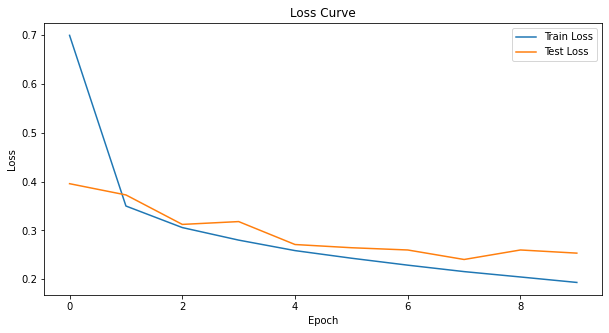

In [ ]:
# Plot the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Valid Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

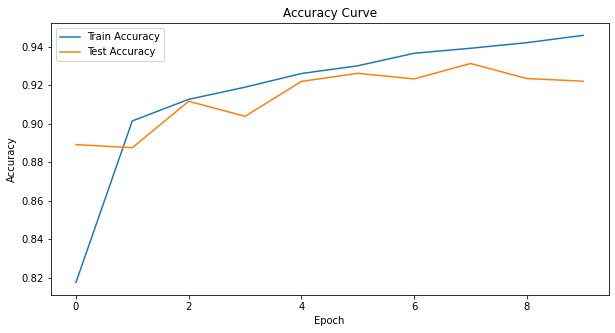

In [ ]:
# Plot the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Valid Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot some prediction

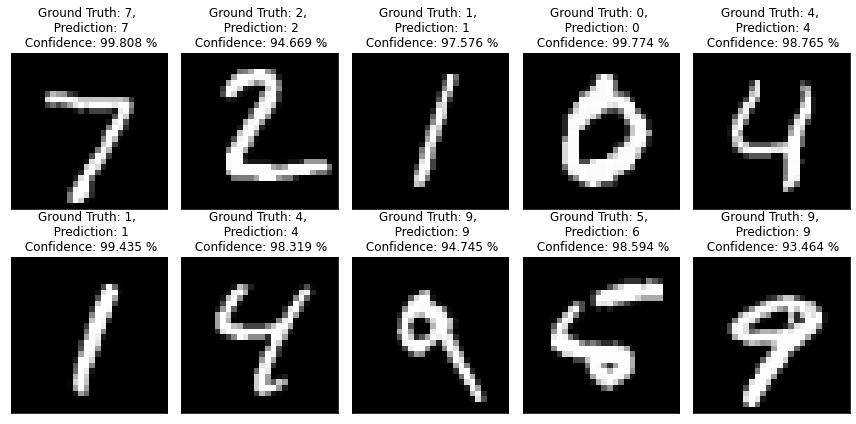

In [19]:
cnn_model.eval()
data, y = next(iter(test_loader))

# 1. push the data to the selected device
data, y = data.to(device), y.to(device)

# 2. feed the data into the model and the model makes predictions
_, logits = cnn_model(data)   # raw prediction before applying softmax ; unnormalised scores for each class

# 3. get the class with highest prob.
y_pred = torch.argmax(logits, 1) # finds the index of the class with the highest value (i.e., the predicted class) along dimension 1,

get_prob = torch.nn.Softmax(dim=1) # converts logits into probabilities that sums to 1
prob = get_prob(logits)            # prob is a tensor where each row corresponds to a sample, and each column contains the probability of that sample belonging to a particular class.

# Plot 
fig = plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].cpu().detach().numpy().reshape((28,28)), cmap='gray')
    
    # detach(): Detaches the tensor from the computation graph, so no gradients are tracked.
    # cpu(): Moves the tensor back to the CPU (important if you're using a GPU).
    # numpy(): Converts the tensor to a NumPy array.
    
    plt.title(f"Ground Truth: {y[i].cpu().detach().numpy()}, \n  Prediction: {y_pred[i].cpu().detach().numpy()} \n Confidence: {prob[i][y_pred[i]] * 100:.3F} %")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout() # Adjusts the subplot parameters to make sure that subplots fit into the figure area nicely, avoiding overlaps.
plt.show()

### Visualize `filter weights`

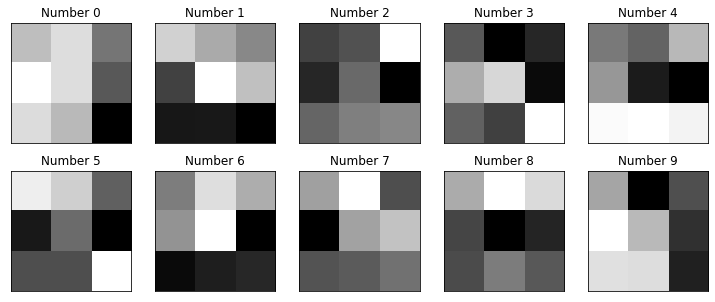

In [20]:
fig = plt.figure(figsize=[5*2.5, 2*2.5])
for i in range(10):                          # loops through first 10 filters,  Each filter corresponds to a learned weight matrix, which is applied to the input image.
  ax = fig.add_subplot(2, 5, i+1)
  # access the ith weight, reshapes to 3*3 matrix  
  ws = cnn_model.conv1.weight[i].reshape([3, 3]).cpu().detach().numpy() # Change here if your filter size is changed 
  ax.imshow(ws, cmap='gray')
  plt.title(f"Number {i}")
  plt.xticks([])
  plt.yticks([])

### Visualize `feature map`

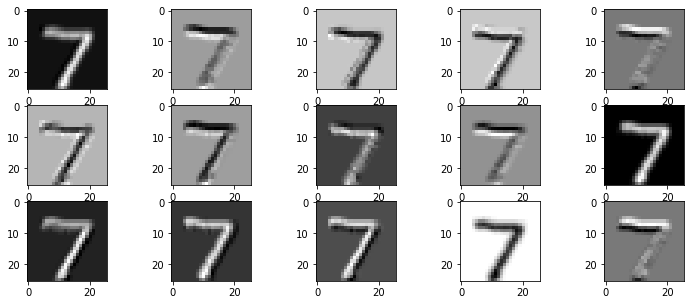

In [22]:
# Visualize feature maps
activation = {}         # initializes empty dictionary to store the feature maps

# returns a hook function,
def get_activation(name):
    # hook will capture the layer's output (output) and store it in the activation dictionary with the specified name.
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

cnn_model.conv1.register_forward_hook(get_activation('conv1')) # This line registers the hook on the first convolutional layer (conv1).
data, _ = test_ds[0]                                           # retrieves a single test sample from the dataset test_ds (data,label)
data.unsqueeze_(0)     # Since this is a single image, unsqueeze_(0) changes its shape from [1, 28, 28] to [1, 1, 28, 28], where 1 is the batch size
output = cnn_model(data.to(device))  # output is not required for this case since we stored activations

fm_cov1 = activation['conv1'].squeeze().cpu().detach().numpy()  # .squeeze(): Removes the extra batch dimension added earlier, so the feature map has the shape [out_channels, height, width].
fig = plt.figure(figsize=[5*2.5, 2*2.5])
for i in range(15):
  ax = fig.add_subplot(3, 5, i+1)
  ax.imshow(fm_cov1[i], cmap='gray')

# The feature maps are the result of applying the learned filters to the input image, so they represent specific patterns or structures detected by the filters. 

## Take HOME RESNET18 model

- Load a pretrained model on Imagenet dataset.

### Keypoints:

1. Customizing the Final Layer: Since ResNet-18's final fully connected (fc) layer is designed for ImageNet (1000 classes), we modify it to suit our dataset by setting resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes).

2. Transformations: The input image size for ResNet-18 is 224x224, so we resize the CIFAR-10 images (originally 32x32) using transforms.Resize(224).

3. Training and Testing: The model is trained using train_model and evaluated using test_model.

In [ ]:
# Load ResNet-18 pre-trained model
from torchvision.models import ResNet18_Weights
resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # or use .DEFAULT for the latest weights

In [22]:
# Modify the final layer to match the number of classes (for example, CIFAR-10 has 10 classes)
num_classes = 10
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

In [23]:
# Transfer the model to the GPU if available
resnet18 = resnet18.to(device)

# Define transforms (resize to 224x224 since ResNet expects that input size)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
# Download CIFAR-10 dataset (or use your own dataset)
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)


# Subsample the training and test datasets

# Function to subsample CIFAR-10 dataset
def subsample_dataset(dataset, sample_size=1000):
    indices = np.random.choice(len(dataset), sample_size, replace=False)
    subset = Subset(dataset, indices)
    return subset

sample_size = 1000
train_subset = subsample_dataset(train_dataset, sample_size=sample_size)
test_subset = subsample_dataset(train_dataset, sample_size=int(sample_size * 0.4))

# Load the data
train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_subset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [ ]:
# Re-write train_model to implement Validation loop and finally use test_model to evaluate the model

# Your code here

In [27]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

In [ ]:
# Training the model
train_model(resnet18, train_loader, criterion, optimizer, num_epochs=5)

Epoch [1/5], Loss: 1.4326


In [ ]:
# Testing the trained model
test_model(resnet18, test_loader)

## Fine-tuning vs. Feature Extraction

- **Fine-tuning**: During fine-tuning, you update the weights of **all layers** in the network during training. This is typically done when you want to adapt a pre-trained model to a new task. By default, when calling `optimizer.step()` on all parameters, the weights of all layers are updated.

- **Feature Extraction**: In feature extraction, you freeze the weights of the pre-trained layers and only train the final layer (or a few newly added layers). This allows the model to use the learned features from the pre-trained network while adjusting the output to the new task.

To freeze the layers in PyTorch, you can set the `requires_grad` attribute of the parameters to `False` like this:

```python
for param in resnet18.parameters():
    param.requires_grad = False
